In [1]:
#| default_exp mplots

In [2]:
#| export
import time
from dataclasses import dataclass, field

In [3]:
#| export
@dataclass
class Time:
    time_start: float =  None
    time_end : float =  None
    time_total : float =  0.0

    def start(self): 
        self.time_start = time.time()
        return self.time_start

    def end(self):
        self.time_end = time.time()
        return self.time_end
        
    def duration(self):
        self.time_total=self.time_end - self.time_start
        return self.time_total

In [4]:
#| hide
# Timer basic example
foo = Time()
foo.start()
time.sleep(2) 
foo.end()
foo.duration()

2.002328395843506

## Mplots functions

In [5]:
#| export
import pyscamp as scamp
import stumpy as stump 
import dvats.memory as mem
import numpy as np

In [6]:
#| hide 
foo_ts = np.random.rand(10000)
foo_m = 50
print("Ts ~ ", foo_ts.shape)
print("Expected mp length: ", int(np.floor(foo_ts.shape[0]-foo_m+1)))

Ts ~  (10000,)
Expected mp length:  9951


In [7]:
#| export
from typing import List

In [8]:
#| export
@dataclass
class MatrixProfile:
    matrix_profile: List[float] =  field(default_factory=list)
    index : List[int] =  field(default_factory=list)
    index_left : List[int] =  field(default_factory=list)
    index_right: List[int] = field(default_factory=list)
    computation_time: float = 0.0
    subsequence_len: int = 0
    method: str = ''
    motif_idx: int = 0
    nearest_neighbor_idx: int = 0
    nearest_neighbor_idx_left: int = 0
    nearest_neighbor_idx_right: int = 0
    def __str__(self):
        return f"MP: {self.matrix_profile}\nIds: {self.index}\nIds_left: {self.index_left}\nIds_right: {self.index_right}\nComputation_time: {self.computation_time}\nsubsequence_len: {self.subsequence_len}\nmethod: {self.method}"

In [9]:
#| hide
foo = MatrixProfile()
print(foo.matrix_profile)
print(foo.index_left)
print(foo)

[]
[]
MP: []
Ids: []
Ids_left: []
Ids_right: []
Computation_time: 0.0
subsequence_len: 0
method: 


In [10]:
#| export
def matrix_profile(
    data, 
    subsequence_len, 
    method = 'scamp', 
    print_flag = False, 
    debug = True, 
    timed = True
):
    if print_flag: print("--> matrix profile")
    duration = 0.0
    mp = []
    index = []
    index_left = []
    index_right = []
    if timed: 
        timer = Time()
        timer.start()
    match method:
        case 'stump':
            if print_flag: print("--> Stump")
            mp = stump.gpu_stump(data, subsequence_len)
            index = mp[:,1]
            index_left = mp[:,2]
            index_right = mp[:,3]
            mp = mp[:,0]
        case 'scamp': 
            if print_flag: print("--> Scamp")
            if debug: 
                print("Check gpu use")
                has_gpu_support = scamp.gpu_supported()
                print(has_gpu_support)
            mp, index = scamp.selfjoin(data, subsequence_len)
        case _: #default scamp
            if print_flag: print("--> Invalid method. Using scamp [default]")
            if debug: 
                has_gpu_support = scamp.gpu_supported()
                print(has_gpu_support)
            mp, index = scamp.selfjoin(data, subsequence_len)            
    if timed: 
        timer.end()
        duration = timer.duration() 
    if print_flag: 
        if timed: 
            print(f"matrix profile {duration} seconds -->")
        else: 
            print("matrix profile -->")
    return mp, index, index_left, index_right, duration

In [11]:
#| export
def compute(self : MatrixProfile, data, subsequence_len, method = 'scamp',  print_flag = False, debug = False, timed = True):
    if print_flag: print("Subsequence len: ", subsequence_len)
    self.subsequence_len = subsequence_len
    self.method = method
    self.matrix_profile, self.index, self.index_left, self.index_right, self.computation_time = matrix_profile(
        data, subsequence_len, method, print_flag, debug, timed)
    return self.matrix_profile
MatrixProfile.compute = compute

In [12]:
foo_mp = MatrixProfile()
print(foo_ts)
print(foo_m)

[0.93117493 0.52103246 0.44416213 ... 0.34434971 0.6602359  0.12584182]
50


In [13]:
#| hide
foo_mp.compute(foo_ts, foo_m, 'scamp', True)
print(foo_mp)

Subsequence len:  50
--> matrix profile
--> Scamp
matrix profile 0.29804062843322754 seconds -->
MP: [6.97269   6.8503933 6.840459  ... 6.9886837 7.0753307 7.0426874]
Ids: [7018 3314 3315 ... 5605 3142 5607]
Ids_left: []
Ids_right: []
Computation_time: 0.29804062843322754
subsequence_len: 50
method: scamp


In [14]:
#| hide
foo_mp_stumpy = matrix_profile(foo_ts, foo_m, 'stump', True, True, True)

--> matrix profile
--> Stump


/usr/local/share/miniconda3/envs/env/lib/python3.10/site-packages/numba/cuda/dispatcher.py:536: NumbaPerformanceWarning: Grid size 20 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))


matrix profile 5.920179605484009 seconds -->


In [15]:
#| hide
foo_mp_stumpy = matrix_profile(foo_ts, foo_m, 'escampo', True, True, True)

--> matrix profile
--> Invalid method. Using scamp [default]
True
matrix profile 0.1167144775390625 seconds -->


In [16]:
#| export
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
from matplotlib.gridspec import GridSpec
from copy import deepcopy

In [34]:
#| export 
from matplotlib.patches import Rectangle

In [36]:
#| export
@dataclass
class MatrixProfiles:
    matrix_profiles: List[MatrixProfile] =  field(default_factory=list)
    data: np.array = field(default_factory=list)
    subsequence_len: int = 0

    def append(self, mp: MatrixProfile):
        self.matrix_profiles.append(deepcopy(mp))
        self.subsequence_len = mp.subsequence_len
    def compute(self : MatrixProfile, method = 'scamp',  print_flag = False, debug = False, timed = True):
        mp = MatrixProfile()
        mp.compute(
            self.data, self.subsequence_len, method, print_flag, debug, timed
        )
        
        mp.method = method
        if print_flag: 
            print("MPs | compute -> Subsequence len out: ", self.subsequence_len)
            print("MPs | compute -> Subsequence len inside: ", mp.subsequence_len)
        self.matrix_profiles.append(mp)
        return mp
    
    def plot(self, ids = []):
        if ids == []: ids = range(len(self.matrix_profiles))
        num_plots = len(ids)+1
        fig = plt.figure(figsize=(10, 6))
        gs = GridSpec(num_plots, 1, height_ratios=[1] + [4] * (num_plots -1))
        # Serie temporal
        ax1 = fig.add_subplot(gs[0])
        ax1.plot(self.data, label="Data")
        ax1.set_title("Time Serie")
        ax1.legend()
        # MPlots
        for i in ids:
            ax2 = fig.add_subplot(gs[i+1], sharex=ax1)
            mp_values = self.matrix_profiles[i].matrix_profile.astype(float)
            ax2.imshow(mp_values.reshape(-1, 1).T, aspect='auto', origin='lower', cmap='hot', extent=(0, len(self.data), 0, self.subsequence_len))
            ax2.set_title(f"MPlot - {i} - {self.matrix_profiles[i].method}")
        plt.tight_layout()
        plt.show()

    def get_motif_idx(self, id): 
        mp_sorted = np.argsort( self.matrix_profiles[id].matrix_profile )
        motif_idx = mp_sorted[0]
        self.matrix_profiles[id].motif_idx = motif_idx
        self.matrix_profiles[id].nearest_neighbor_idx = self.matrix_profiles[id].index[motif_idx]
        
        if ( self.matrix_profiles[id].method == 'stump' ):
            self.matrix_profiles[id].nearest_neighbor_idx_left = self.matrix_profiles[id].index_left[motif_idx]
            self.matrix_profiles[id].nearest_neighbor_idx_right = self.matrix_profiles[id].index_right[motif_idx]
        return self.matrix_profiles[id].motif_idx, self.matrix_profiles[id].nearest_neighbor_idx, self.matrix_profiles[id].nearest_neighbor_idx_left, self.matrix_profiles[id].nearest_neighbor_idx_right
            

    def plot_motif(
        self, 
        ts_name,
        id, 
        motif_idx, 
        nearest_neighbor_idx, 
        title_fontsize = '30', 
        other_fontsize = '20'
    ): 
        fig, axs = plt.subplots(2, sharex=True, gridspec_kw={'hspace': 0.4})
        plt.suptitle('Motif (Pattern) Discovery | ' + self.matrix_profiles[id].method , fontsize=title_fontsize)

        axs[0].plot(self.data.values)
        axs[0].set_ylabel(ts_name, fontsize=other_fontsize)
        rect = Rectangle((motif_idx, 0), self.subsequence_len, 40, facecolor='lightgrey')
        axs[0].add_patch(rect)
        rect = Rectangle((nearest_neighbor_idx, 0), self.subsequence_len, 40, facecolor='lightgrey')
        axs[0].add_patch(rect)
        axs[1].set_xlabel('Index', fontsize =other_fontsize)
        axs[1].set_ylabel('Matrix Profile', fontsize=other_fontsize)
        axs[1].axvline(x=motif_idx, linestyle="dashed", color = "black")
        axs[1].axvline(x=nearest_neighbor_idx, linestyle="dashed", color="red")
        axs[1].plot(self.matrix_profiles[id].matrix_profile)
        plt.show()
        
        


In [18]:
#| hide
foo_mps = MatrixProfiles()
foo_mps.data = foo_ts
foo_mps.subsequence_len = 50
print("Ts ~ ", foo_mps.data.shape)
print("Expected mp length: ", int(np.floor(foo_mps.data.shape[0]-foo_mps.subsequence_len+1)))
foo_mps.compute('stump',  True, True, True)
print("Total MPs: ", len(foo_mps.matrix_profiles))
print(foo_mps.matrix_profiles[0])
foo_mps.compute('scamp',  True, True, True)
print("Total MPs: ", len(foo_mps.matrix_profiles))
print(foo_mps.matrix_profiles[1])

Ts ~  (10000,)
Expected mp length:  9951
Subsequence len:  50
--> matrix profile
--> Stump
matrix profile 2.2186570167541504 seconds -->
MPs | compute -> Subsequence len out:  50
MPs | compute -> Subsequence len inside:  50
Total MPs:  1
MP: [6.972690172347554 6.850393403863808 6.840458603524715 ...
 6.988683566447894 7.075330913808945 7.042687188796608]
Ids: [7018 3314 3315 ... 5605 3142 5607]
Ids_left: [-1 -1 -1 ... 5605 3142 5607]
Ids_right: [7018 3314 3315 ... -1 -1 -1]
Computation_time: 2.2186570167541504
subsequence_len: 50
method: stump
Subsequence len:  50
--> matrix profile
--> Scamp
Check gpu use
True
matrix profile 0.07978439331054688 seconds -->
MPs | compute -> Subsequence len out:  50
MPs | compute -> Subsequence len inside:  50
Total MPs:  2
MP: [6.97269   6.8503933 6.840459  ... 6.9886837 7.0753307 7.0426874]
Ids: [7018 3314 3315 ... 5605 3142 5607]
Ids_left: []
Ids_right: []
Computation_time: 0.07978439331054688
subsequence_len: 50
method: scamp


In [20]:
#| export
import pandas as pd

In [37]:
#| hide
steam_df = pd.read_csv("https://zenodo.org/record/4273921/files/STUMPY_Basics_steamgen.csv?download=1")
steam_df.head()
steam_mps = MatrixProfiles()
steam_mps.subsequence_len = 640
steam_mps.data = steam_df['steam flow']
steam_mps.compute('scamp', print_flag = True, debug = False, timed = True)
steam_mps.compute('stump', print_flag = True, debug = False, timed = True)
print(foo_mps.get_motif_idx(0))
print(foo_mps.get_motif_idx(1))

Subsequence len:  640
--> matrix profile
--> Scamp
matrix profile 0.16942524909973145 seconds -->
MPs | compute -> Subsequence len out:  640
MPs | compute -> Subsequence len inside:  640
Subsequence len:  640
--> matrix profile
--> Stump
matrix profile 3.1195285320281982 seconds -->
MPs | compute -> Subsequence len out:  640
MPs | compute -> Subsequence len inside:  640
(855, 5269, 10, 5269)
(5269, 855, 0, 0)


In [38]:
#| hide
steam_mps.get_motif_idx(0)
steam_mps.get_motif_idx(1)
print(steam_mps.matrix_profiles[1].motif_idx)
print(steam_mps.matrix_profiles[1].nearest_neighbor_idx)
print(steam_mps.matrix_profiles[1].nearest_neighbor_idx_left)
print(steam_mps.matrix_profiles[1].nearest_neighbor_idx_right)

643
8724
296
8724


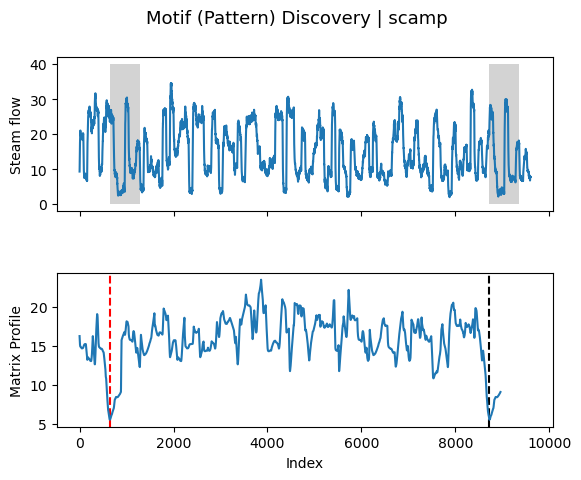

In [41]:
#| hide
stumpy_idxs = steam_mps.get_motif_idx(0)
steam_mps.plot_motif(
    ts_name = 'Steam flow', 
    id = 0, 
    motif_idx = stumpy_idxs[0], 
    nearest_neighbor_idx = stumpy_idxs[1], 
    title_fontsize = '13', 
    other_fontsize = '10'
)

In [ ]:
#| hide
foo_mps = MatrixProfiles()

In [ ]:
#| hide
foo_mps.data = foo_ts
foo_mps.sequence_len = foo_m
foo_mp.compute(foo_ts, foo_m, 'scamp', True)
foo_mps.append(foo_mp)
print(foo_mp.method)
print(foo_mps.matrix_profiles[0].method)
foo_mp.compute(foo_ts, foo_m, 'stumpy', True)
foo_mps.append(foo_mp)
print(foo_mps.matrix_profiles[0].method)
print(foo_mps.matrix_profiles[1].method)

In [ ]:
#| hide
foo_mps.plot([])

In [ ]:
#| hide 
print(foo_mps.matrix_profiles[0].computation_time)
print(foo_mps.matrix_profiles[1].computation_time)

## Plotting auxiliar functions

In [ ]:
#| export
import dvats.load as load
import os
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as dates
from matplotlib.patches import Rectangle
import datetime as dt
from mpl_toolkits.axes_grid1 import ImageGrid
from matplotlib.gridspec import GridSpec
plt.style.use('https://raw.githubusercontent.com/TDAmeritrade/stumpy/main/docs/stumpy.mplstyle')

In [ ]:
#| export
def plot_dataFrame(title, df, vars = [], interval = 10000):
    if len(vars) > 0:
        num_vars = len(df.columns)
    
        for var_num in vars:
            if var_num >= len(df.columns):
                raise ValueError("var_num "+var[var_num] + "is out of the range of DataFrame columns: " + num_vars)

        num_vars = len(vars)
        
        ### Start the plot 

        #fig = plt.figure(figsize=(10, num_intervals * 3))  # Ajusta el tamaño del plot según el número de intervalos
        
        num_intervals = df.shape[0] // interval + 1
        fig = plt.figure(figsize=(10, num_vars * num_intervals * 3))  ## Size
        gs = GridSpec(num_intervals*num_vars, 1) # 1 column, len(vars) rows
        var_pos = 0
        for var_num  in vars:
            var_name = df.columns[var_num]
            data = df[var_name]
            for i in range(num_intervals):    
                start_idx = i * interval
                end_idx = len(data) if i == (num_intervals - 1) else start_idx + interval
                ax = fig.add_subplot(gs[var_pos+i])
                ax.plot(np.arange(start_idx, end_idx), data[start_idx:end_idx], label=f"{var_name} [{start_idx}, {end_idx}]")
                ax.set_title(f"{var_name} [{start_idx}, {end_idx}]")
                ax.set_xlabel("Time")
                ax.set_ylabel(var_name)
                ax.legend()
            var_pos += 1
                
        plt.suptitle(title, fontsize=16)
        plt.tight_layout()
        plt.show()
    else: raise ValueError("No variable proposed for plotting")

In [ ]:
#| export 
def plot_dataFrame_compareSubsequences(
    title, df, var, subsequence_len, seq1_init, seq2_init, 
    title_fontsize = '30',
    others_fontsize='20'
):
    fig, axs = plt.subplots(2)
    fig.subplots_adjust(hspace=0.4) 
    plt.suptitle(title, fontsize=title_fontsize)
    var_name = df.columns[var]
    axs[0].set_ylabel(var_name, fontsize=others_fontsize)
    axs[0].plot(df[var_name], alpha=0.5, linewidth=1)
    axs[0].plot(df[var_name].iloc[seq1_init:seq1_init+subsequence_len])
    axs[0].plot(df[var_name].iloc[seq2_init:seq2_init+subsequence_len])
    rect = Rectangle((seq1_init, 0), subsequence_len, 40, facecolor='lightgrey')
    axs[0].add_patch(rect)
    axs[0].set_xlabel("Index", fontsize=others_fontsize)

    rect = Rectangle((seq2_init, 0), subsequence_len, 40, facecolor='lightgrey')
    axs[0].add_patch(rect)
    axs[1].set_xlabel("Relative Index (subsequence)", fontsize=others_fontsize)
    axs[1].set_ylabel(var_name, fontsize=others_fontsize)
    axs[1].plot(df[var_name].values[seq1_init:seq1_init+subsequence_len], color='C1')
    axs[1].plot(df[var_name].values[seq2_init:seq2_init+subsequence_len], color='C2')
    plt.show()
    

In [ ]:
#| hide
import pandas as pd
steam_df = pd.read_csv("https://zenodo.org/record/4273921/files/STUMPY_Basics_steamgen.csv?download=1")
steam_df.head()
plot_dataFrame_compareSubsequences('Steamgen Dataset', steam_df, 3, 640, 643, 8724, '16', '10')

In [ ]:
#| export
def df_plot_colored_variables(df):
    # Show time series plot
    fig, ax = plt.subplots(1, figsize=(15,5), )
    cmap = matplotlib.colormaps.get_cmap('viridis')
    #df.plot(color=cmap(0.05), ax=ax) # or use colormap=cmap
    df.plot(colormap=cmap, ax=ax) # or use colormap=cmap
    # rect = Rectangle((5000, -4.2), 3000, 8.4, facecolor='lightgrey', alpha=0.5)
    # ax.add_patch(rect)
    plt.tight_layout()
    plt.legend()
    display(plt.show())

In [ ]:
#| export
def plot_df_with_intervals_and_colors(title, df, interval=10000):
    num_variables = len(df.columns)
    num_intervals = len(df) // interval + 1  # Calcula el número necesario de intervalos/subplots

    fig = plt.figure(figsize=(10, num_intervals * 3 * num_variables))  # Ajusta el tamaño del plot
    gs = GridSpec(num_intervals * num_variables, 1)
    
    cmap = matplotlib.colormaps.get_cmap('viridis')

    for var_num, var in enumerate(df.columns):
        data = df[var]
        for i in range(num_intervals):
            ax = fig.add_subplot(gs[var_num * num_intervals + i])
            start_idx = i * interval
            end_idx = start_idx + interval

            if i == num_intervals - 1:  # Ajusta el último intervalo para incluir todos los datos restantes
                end_idx = len(data)

            color = cmap(var_num / num_variables)  # Asigna un color basado en la variable
            ax.plot(np.arange(start_idx, end_idx), data[start_idx:end_idx], label=f"{var} [{start_idx}, {end_idx}]", color=color)
            ax.set_title(f"{var} [{start_idx}, {end_idx}]")
            ax.set_xlabel("Index")
            ax.set_ylabel(var)
            ax.legend()

    plt.suptitle(title, fontsize=16)
    plt.tight_layout()
    plt.show()

In [ ]:
#| export
def plot_motif(df, motif_idx, nearest_neighbor_idx, variable_name, title, padding = 1000, m = 1, mp = None):
    fig, axs = plt.subplots(2, sharex = True, gridspec_kw={'hspace': 0})
    plt.suptitle('Motif (Pattern) Discovery', fontsize='30')
    padding = min(padding, len(df[variable_name].values) // 2)

    # Calcula los límites para hacer zoom
    x_min = max(min(motif_idx, nearest_neighbor_idx) - padding, 0)
    x_max = min(max(motif_idx, nearest_neighbor_idx) + padding, len(df[variable_name].values))

    axs[0].plot(df[variable_name].values)
    axs[0].set_xlim([x_min, x_max])  # Aplica el zoom aquí
    axs[0].set_ylabel(title, fontsize='20')
        
    axs[0].set_ylabel(title, fontsize='20')
    rect = Rectangle((motif_idx, 0), m, 40, facecolor='lightgrey')
    axs[0].add_patch(rect)
    rect = Rectangle((nearest_neighbor_idx, 0), m, 40, facecolor='lightgrey')
    axs[0].add_patch(rect)
    axs[1].set_xlabel('Time', fontsize ='20')
    axs[1].set_ylabel('Matrix Profile', fontsize='20')
    axs[1].axvline(x=motif_idx, linestyle="dashed")
    axs[1].axvline(x=nearest_neighbor_idx, linestyle="dashed")
    axs[1].plot(mp)
    plt.show()

In [ ]:
#| export
def plot_motif_separated(df, motif_idx=0, nearest_neighbor_idx=0, variable_name="", title="", padding=1000, m=1, mp=None):
    fig, axs = plt.subplots(4, sharex=False, figsize=( 12, 5), gridspec_kw={'hspace': 0.5})
    plt.suptitle('Motif (Pattern) Discovery', fontsize='20')
    
    padding = max(m, min(padding, len(df[variable_name].values) // 2))

    x_min_motif = max(motif_idx - padding, 0)
    x_max_motif = min(motif_idx + padding, len(df[variable_name].values))

    axs[0].plot(df[variable_name].values)
    axs[0].set_xlim([x_min_motif, x_max_motif])
    axs[0].set_ylabel(title, fontsize='10')
    rect_motif = Rectangle((motif_idx, df[variable_name].min()), m, df[variable_name].max() - df[variable_name].min(), facecolor='lightgrey')
    axs[0].add_patch(rect_motif)

    axs[1].plot(mp)
    axs[1].set_xlim([x_min_motif, x_max_motif])
    axs[1].set_xlabel('Time', fontsize='10')
    axs[1].set_ylabel('MP - Min', fontsize='10')
    axs[1].axvline(x=motif_idx, linestyle="dashed")

    x_min_neighbor = max(nearest_neighbor_idx - padding, 0)
    x_max_neighbor = min(nearest_neighbor_idx + padding, len(df[variable_name].values))

    axs[2].plot(df[variable_name].values)
    axs[2].set_xlim([x_min_neighbor, x_max_neighbor])
    axs[2].set_ylabel(title, fontsize='10')
    rect_neighbor = Rectangle((nearest_neighbor_idx, df[variable_name].min()), m, df[variable_name].max() - df[variable_name].min(), facecolor='lightgrey')
    axs[2].add_patch(rect_neighbor)

    axs[3].plot(mp)
    axs[3].set_xlim([x_min_neighbor, x_max_neighbor])
    axs[3].set_xlabel('Time', fontsize='10')
    axs[3].set_ylabel('MP-max', fontsize='10')
    axs[3].axvline(x=nearest_neighbor_idx, linestyle="dashed")

    plt.show()

# Download & load matrices

In [ ]:
#| export
class GD_Mat:
    def __init__(self, id,  name, data_path = '~/data'):
        self.id = id
        self.data_path = os.path.expanduser(data_path)
        self.zip_path = os.path.join(self.data_path, name + '.zip')
        self.mat_path = os.path.join(self.data_path, name + '.mat')
        self.mats_files = None
        self.mats = None
        self.mats_df =  None
        self.num_mats = 0
        self.num_mats_extracted = 0
        
    def download_file_from_google_drive(self):
        return load.download_file_from_google_drive(self.id, self.zip_path)
        
    def get_mat_files(self):
        self.mats_files = [f for f in load.zip_contents(self.zip_path) if not f.startswith('__MACOSX/')]
        self.num_mats = len(self.mats_files)
        self.mats = self.mats_df = [None]*self.num_mats
    
    def unzip_mat(self, all_one, case = '', print_flag = False): 
        str = load.unzip_mat(all_one, self.zip_path, self.data_path, case, print_flag)
        self.get_mat_files()
        return str
        
    def mat2csv(self, case_id, print_flag = False):
        if print_flag: print("--> mat2csv", case_id)
        case = self.mats_files[case_id]
        case_path = os.path.join(self.data_path, case)
        print("Mat2csv case", case_path)
        self.mats_df[case_id] = load.mat2csv(case_path, self.data_path, print_flag)
        if print_flag: print("mat2csv", case_id, "-->")
        
    def __str__(self): 
        str = f"FileID: {self.id}\nData path: {self.data_path}\n"
        str += f"zip path: {self.zip_path}\nmat_files: {self.mats_files}"
        str +=f"\nnum_mats: {self.num_mats}"
        return str
    

In [ ]:
#| hide 
file_id = '1qq1z2mVRd7PzDqX0TDAwY7BcWVjnXUfQ'
name = 'InsectData-fig11'

gd_mat = GD_Mat(file_id, name)
print(gd_mat)
gd_mat.unzip_mat('all')
print(gd_mat)
gd_mat.mat2csv(0)
print(gd_mat)
display(gd_mat.mats_df[0].head(5))

## Global variables

In [ ]:
#| export
eamonn_drive_mplots = {
    'insects0': {
        'id': '1qq1z2mVRd7PzDqX0TDAwY7BcWVjnXUfQ',
        'name': 'InsectData-fig11'
    }
}

In [ ]:
#| hide 
eammon_drive_mplots['insects0']['name']